In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [12]:
# Create our features
# Convert string columns to numbers and drop 'loan_status' column then assign to X
X = pd.get_dummies(df, columns=['home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 
                'initial_list_status', 'next_pymnt_d', 'application_type', 'hardship_flag', 
                'debt_settlement_flag']).drop(['loan_status', 
'num_rev_tl_bal_gt_0',
'loan_amnt',
'inq_last_12m',
'num_bc_tl',
'num_op_rev_tl',
'mo_sin_rcnt_tl',
'num_actv_bc_tl',
'total_cu_tl',
'percent_bc_gt_75',
'num_sats',
'num_actv_rev_tl',
'open_acc',
'acc_open_past_24mths',
'inq_fi',
'num_il_tl',
'open_il_24m',
'num_bc_sats',
'open_act_il',
'open_rv_24m',
'mort_acc',
'total_rec_late_fee',
'num_tl_op_past_12m',
'open_acc_6m',
'next_pymnt_d_Apr-2019',
'open_rv_12m',
'open_il_12m',
'issue_d_Feb-2019',
'next_pymnt_d_May-2019',
'inq_last_6mths',
'delinq_2yrs',
'num_accts_ever_120_pd',
'tot_coll_amt',
'home_ownership_OWN',
'home_ownership_MORTGAGE',
'verification_status_Source Verified',
'verification_status_Verified',
'verification_status_Not Verified',
'home_ownership_RENT',
'pub_rec_bankruptcies',
'pub_rec',
'initial_list_status_f',
'application_type_Individual',
'num_tl_90g_dpd_24m',
'initial_list_status_w',
'application_type_Joint App',
'collections_12_mths_ex_med',
'home_ownership_ANY',
'tax_liens',
'recoveries',
'pymnt_plan_n',
'policy_code',
'num_tl_30dpd',
'num_tl_120dpd_2m',
'hardship_flag_N',
'delinq_amnt',
'debt_settlement_flag_N',
'collection_recovery_fee',
'chargeoff_within_12_mths',
'acc_now_delinq'], axis=1)

# Create our target
y = df['loan_status']
X.head()

,int_rate,installment,annual_inc,dti,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,mths_since_recent_bc,mths_since_recent_inq,num_rev_accts,pct_tl_nvr_dlq,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_d_Jan-2019,issue_d_Mar-2019
0,0.1719,375.35,66000.0,27.24,1609.0,14.0,10204.87,10204.87,355.29,355.29,...,20.0,1.0,3.0,85.7,65687.0,38199.0,2000.0,61987.0,0,1
1,0.2000,929.09,105000.0,20.23,18368.0,34.0,24293.13,24293.13,873.53,873.53,...,1.0,11.0,18.0,91.2,271427.0,60641.0,41200.0,49197.0,0,1
2,0.2000,529.88,56000.0,24.26,13247.0,21.0,19636.79,19636.79,485.44,485.44,...,7.0,7.0,13.0,66.7,60644.0,45684.0,7500.0,43144.0,0,1
3,0.1640,353.55,92000.0,31.44,17996.0,23.0,9719.34,9719.34,335.33,335.33,...,34.0,0.0,6.0,100.0,99506.0,68784.0,19700.0,76506.0,0,1
4,0.1474,520.39,52000.0,18.76,9091.0,28.0,21614.73,21614.73,484.36,484.36,...,11.0,0.0,18.0,100.0,219750.0,25919.0,27600.0,20000.0,0,1


In [13]:
X.describe()

,int_rate,installment,annual_inc,dti,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,mths_since_recent_bc,mths_since_recent_inq,num_rev_accts,pct_tl_nvr_dlq,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_d_Jan-2019,issue_d_Mar-2019
count,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04,68817.000000,68817.000000
mean,0.127718,480.652863,8.821371e+04,21.778153,17604.142828,24.666347,16018.845833,16015.919519,970.639473,970.431151,...,24.714954,7.688028,13.517663,95.057627,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04,0.451066,0.177238
std,0.048130,288.062432,1.155800e+05,20.199244,21835.880400,12.318917,10002.695495,10004.985940,1229.563301,1229.569864,...,32.130889,6.034861,8.026158,8.326426,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04,0.497603,0.381873
min,0.060000,30.890000,4.000000e+01,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,20.000000,3.600000e+03,2.350000e+02,100.000000,1.270000e+02,0.000000,0.000000
25%,0.088100,265.730000,5.000000e+04,13.890000,6293.000000,16.000000,8578.800000,8576.500000,403.760000,403.550000,...,6.000000,3.000000,8.000000,93.000000,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04,0.000000,0.000000
50%,0.118000,404.560000,7.300000e+04,19.760000,12068.000000,23.000000,14067.750000,14061.030000,710.790000,710.790000,...,15.000000,6.000000,12.000000,100.000000,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04,0.000000,0.000000
75%,0.155700,648.100000,1.040000e+05,26.660000,21735.000000,31.000000,22860.700000,22860.490000,1214.600000,1214.590000,...,31.000000,12.000000,17.000000,100.000000,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04,1.000000,0.000000
max,0.308400,1676.230000,8.797500e+06,999.000000,587191.000000,164.000000,40000.000000,40000.000000,41418.981165,41418.980000,...,564.000000,24.000000,98.000000,100.000000,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06,1.000000,1.000000


In [14]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [16]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
# Instantiate
brfc = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

# Fit
brfc.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=1)

In [17]:
# Calculated the balanced accuracy score
y_pred = brfc.predict(X_test)
random_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f'Random Accuracy: {random_accuracy}')

Random Accuracy: 0.785153558867254


In [18]:
# Display the confusion matrix
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix - Balance Random Forest")
# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df.to_csv('conf_matrix_Random_Forest.csv')
cm_df

Confusion Matrix - Balance Random Forest


,Predicted high_risk,Predicted low_risk
Actual high_risk,60,27
Actual low_risk,2043,15075


In [19]:
# Print the imbalanced classification report
print("Classification Report - Balance Random Forest")
print(classification_report_imbalanced(y_test, y_pred))

Classification Report - Balance Random Forest
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.69      0.88      0.05      0.78      0.60        87
   low_risk       1.00      0.88      0.69      0.94      0.78      0.62     17118

avg / total       0.99      0.88      0.69      0.93      0.78      0.62     17205



In [20]:
# List the features sorted in descending order (reverse=True) by feature importance
features_rank = sorted(zip(brfc.feature_importances_, X.columns), reverse=True)
for feature in features_rank:
    print(f"{feature[1]}: ({feature[0]})")

total_rec_prncp: (0.09487234185226857)
last_pymnt_amnt: (0.0753384976161592)
total_pymnt: (0.07218223011708955)
total_rec_int: (0.0698687546251604)
total_pymnt_inv: (0.06637433703012359)
int_rate: (0.03622049340055908)
mths_since_recent_inq: (0.027627537027521118)
issue_d_Jan-2019: (0.027036000795333363)
issue_d_Mar-2019: (0.025681966713309586)
installment: (0.025210785144494773)
dti: (0.024938559240856046)
out_prncp: (0.024086241014050474)
max_bal_bc: (0.023484705738845903)
out_prncp_inv: (0.02318527967613958)
annual_inc: (0.02293762055927651)
avg_cur_bal: (0.02267326582324346)
bc_util: (0.02112372678980298)
tot_hi_cred_lim: (0.020398464592373915)
mths_since_rcnt_il: (0.019904034294784108)
mo_sin_rcnt_rev_tl_op: (0.01885351241043862)
mo_sin_old_rev_tl_op: (0.01865079873501295)
revol_bal: (0.018310878613053073)
mo_sin_old_il_acct: (0.018278482594802033)
total_bal_ex_mort: (0.018253542905369735)
il_util: (0.018251534997961557)
total_bc_limit: (0.0174486116571491)
mths_since_recent_bc: (

### Easy Ensemble AdaBoost Classifier

In [21]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
# Instantiate
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)

# Fit
eec.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [22]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test)
ADA_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f'Ada Accuracy: {ADA_accuracy}')

Ada Accuracy: 0.8260562585864446


In [23]:
# Display the confusion matrix
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix - ADABoost")
# Create a DataFrame from the confusion matrix.

cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df.to_csv('conf_matrix_ADABoost.csv')
cm_df

Confusion Matrix - ADABoost


,Predicted high_risk,Predicted low_risk
Actual high_risk,71,16
Actual low_risk,2807,14311


In [24]:
# Print the imbalanced classification report
print("Classification Report - ADABoost")
print(classification_report_imbalanced(y_test, y_pred))

Classification Report - ADABoost
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.82      0.84      0.05      0.83      0.68        87
   low_risk       1.00      0.84      0.82      0.91      0.83      0.68     17118

avg / total       0.99      0.84      0.82      0.91      0.83      0.68     17205



In [25]:
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

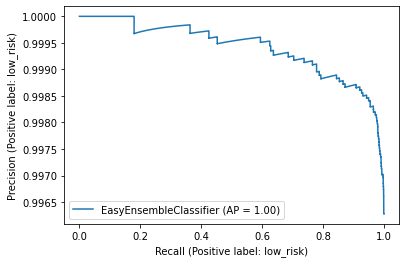

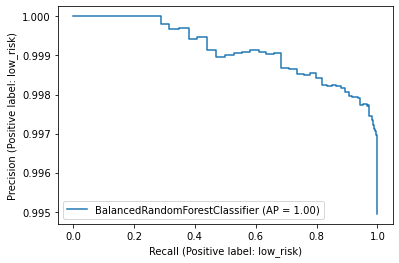

In [26]:
# Using Matplolib create a chart of Precision-Recall Curve
Ada_disp = plot_precision_recall_curve(eec, X_test, y_test)
Random_disp = plot_precision_recall_curve(brfc, X_test, y_test)

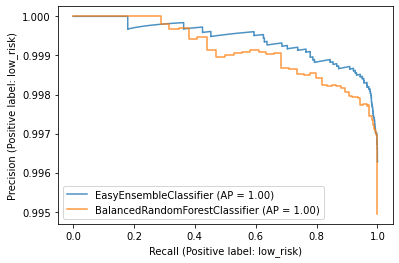

In [27]:
# Put the Precision-Recall Curve in the same axis 
ax = plt.gca()
Ada_disp.plot(ax=ax, alpha=0.8)
Random_disp.plot(ax=ax, alpha=0.8)
#  We can see that the Easy Ensemble model has a better performance and a higher area

Balanced Random Forest with selected columns

In [28]:
cm_df

,Predicted high_risk,Predicted low_risk
Actual high_risk,71,16
Actual low_risk,2807,14311
